### Coding with Qiskit 1

Before solving this notebook, make sure you have `Qiskit > 1.0` or higher and `Qiskit-ibm-runtime > 0.28` or higher installed. You must use `EstimatorV2` for your solution.

In [ ]:
pip install 'qiskit>=1'

In [ ]:
pip install qiskit-ibm-runtime

In [ ]:
pip install qiskit-aer

In [ ]:
pip show qiskit-aer

In [365]:
import numpy as np
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit_ibm_runtime.fake_provider import FakeKolkataV2
from qiskit.circuit.library import ZGate
from qiskit.quantum_info import SparsePauliOp
from qiskit import transpile
from qiskit_aer import AerSimulator 
from qiskit.quantum_info import Statevector
from qiskit.primitives import StatevectorEstimator
import matplotlib.pyplot as plt

#### Creating the quantum circuit

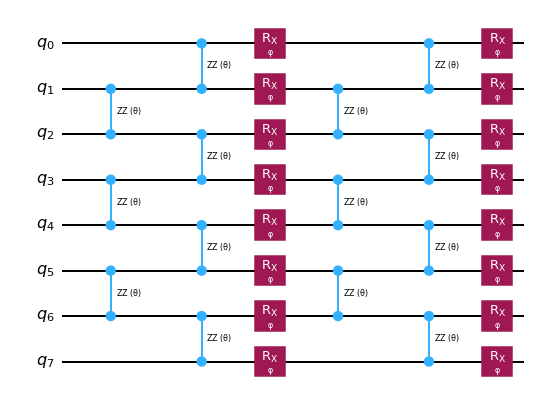

In [375]:
from qiskit.circuit import QuantumCircuit, Parameter

theta = Parameter('θ')
phi = Parameter('φ')
num_qubits = 8
num_steps = 2

qc = QuantumCircuit(num_qubits)
for _ in range(num_steps):
    for i in range(1, num_qubits-1, 2):
        qc.rzz(theta, i, i+1)
    for i in range(0, num_qubits, 2):
        qc.rzz(theta, i, i+1)
    for i in range(num_qubits):
        qc.rx(phi, i)

qc.draw('mpl', fold=-1)

The goal of this exercise will be to calculate the ideal and noisy expectation values of the specified observables for a range of parameter values. In particular, both $\theta$ and $\phi$ will be varied between $0$ and $\pi$ in 5 equal intervals.

#### Q1. Generate parameters

In this step you need to generate 5 equal interval values between $[0,\pi]$ for each of $\theta$ and $\phi$. Create a copy of the circuit, assign a parameter of your choice, and draw the circuit.

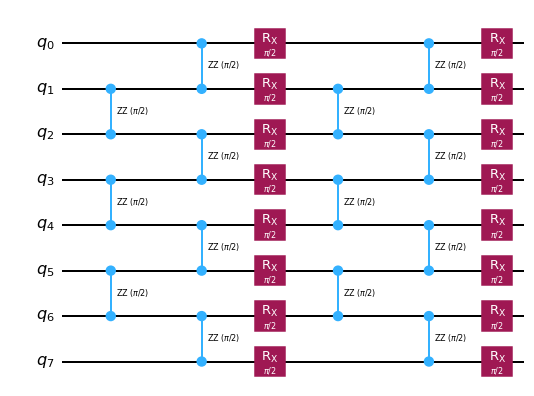

In [384]:
### Your solution here
# Generate 5 equally spaced values for θ and φ
theta_values = np.linspace(0, np.pi, 5)  # θ in [0, π]
phi_values = np.linspace(0, np.pi, 5)  # φ in [0, π]

# Choose one value for demonstration
chosen_theta = theta_values[2]  # Use the third value as an example
chosen_phi = phi_values[2]      # Use the third value as an example

# Create a new circuit and bind the chosen parameters
bound_qc = qc.assign_parameters({theta: chosen_theta, phi: chosen_phi})

# Draw the bound circuit
bound_qc.draw('mpl', fold=-1)

#### Q2. Transpile the circuit

In this step you will consider `FakeKolkataV2` as your `backend`. 

- Transpile the circuit on this backend.
- Print the different gates and their counts in the transpiled circuit.
- Print the layout (i.e., the physical qubits on which the circuit is placed) of the transpiled circuit.

Gate counts in the transpiled circuit:
OrderedDict([('rz', 62), ('sx', 32), ('cx', 28)])

Layout (physical qubits mapping):
TranspileLayout(initial_layout=Layout({
25: Qubit(QuantumRegister(8, 'q'), 1),
24: Qubit(QuantumRegister(8, 'q'), 2),
26: Qubit(QuantumRegister(8, 'q'), 0),
23: Qubit(QuantumRegister(8, 'q'), 3),
21: Qubit(QuantumRegister(8, 'q'), 4),
18: Qubit(QuantumRegister(8, 'q'), 5),
15: Qubit(QuantumRegister(8, 'q'), 6),
12: Qubit(QuantumRegister(8, 'q'), 7),
0: Qubit(QuantumRegister(19, 'ancilla'), 0),
1: Qubit(QuantumRegister(19, 'ancilla'), 1),
2: Qubit(QuantumRegister(19, 'ancilla'), 2),
3: Qubit(QuantumRegister(19, 'ancilla'), 3),
4: Qubit(QuantumRegister(19, 'ancilla'), 4),
5: Qubit(QuantumRegister(19, 'ancilla'), 5),
6: Qubit(QuantumRegister(19, 'ancilla'), 6),
7: Qubit(QuantumRegister(19, 'ancilla'), 7),
8: Qubit(QuantumRegister(19, 'ancilla'), 8),
9: Qubit(QuantumRegister(19, 'ancilla'), 9),
10: Qubit(QuantumRegister(19, 'ancilla'), 10),
11: Qubit(QuantumRegister(1

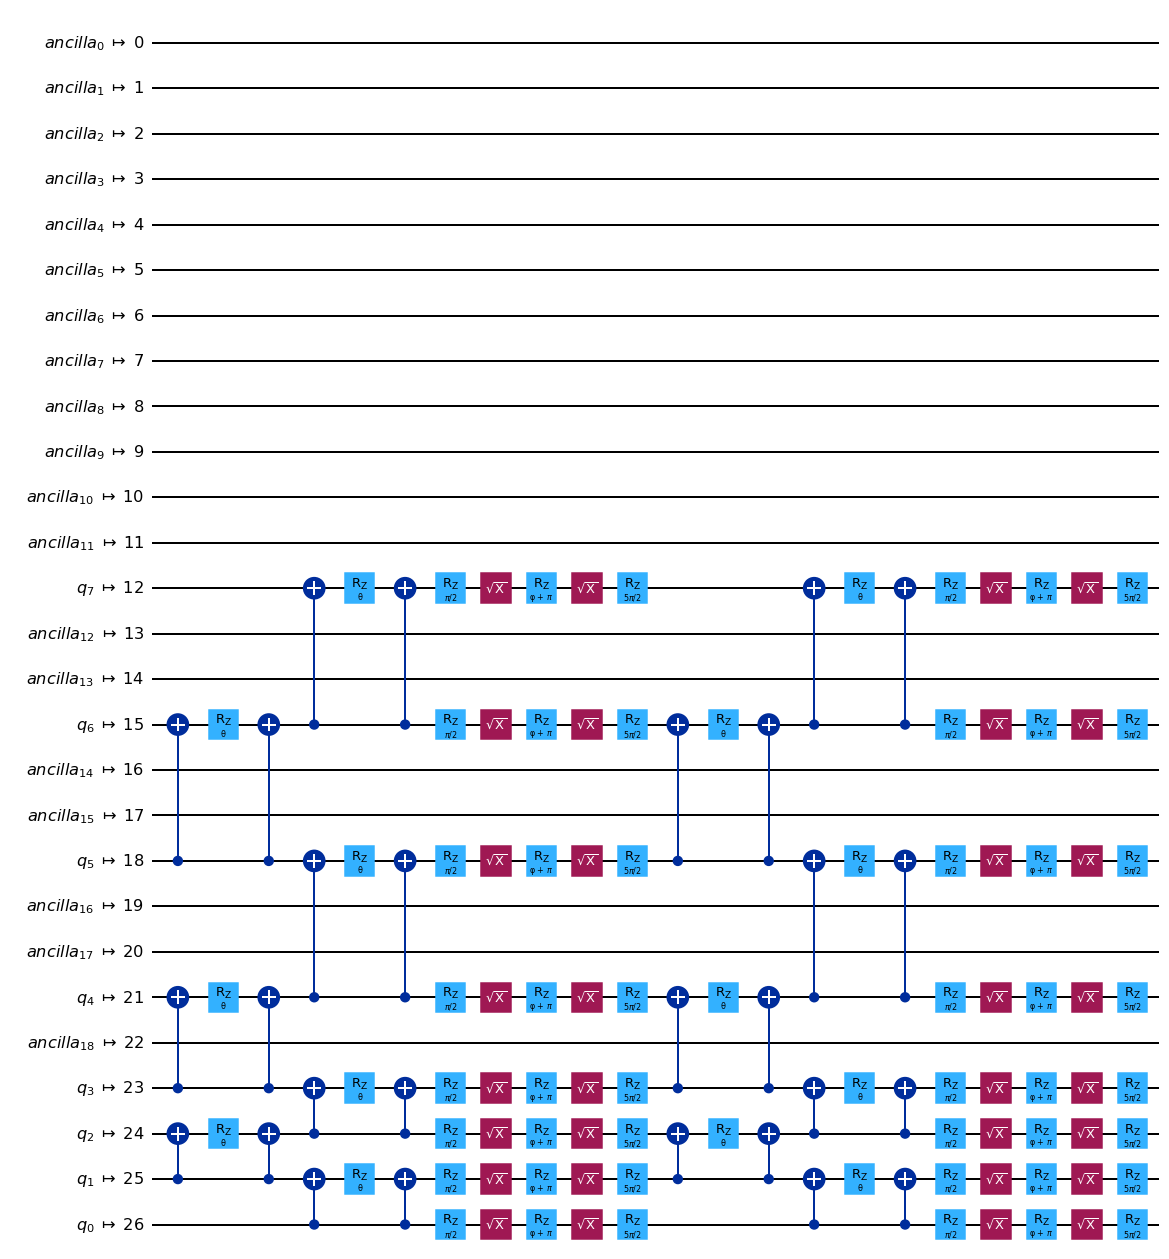

In [392]:
### Your solution here
# Select backend and transpile
backend = FakeKolkataV2()
transpiled_qc = transpile(qc, backend=backend)

# Print gate counts
print("Gate counts in the transpiled circuit:")
print(transpiled_qc.count_ops())

# Print layout
print("\nLayout (physical qubits mapping):")
print(transpiled_qc.layout)

# Draw the transpiled circuit
transpiled_qc.draw('mpl', fold=-1)

#### Q3. Construct observable

In this step you will

- Construct the following observable: $\sum_{i=1}^{N}\langle Z_i \rangle / N$ where $N$ is the number of qubits.
- Apply the layout of the transpiled circuit to this observable. Print the observable after applying layout.

In [394]:
from qiskit.quantum_info import SparsePauliOp

# Number of qubits
N = num_qubits

# Construct the observable
pauli_terms = []
coefficients = []

# Generate terms for ⟨Z₁⟩, ⟨Z₂⟩, ..., ⟨Zₙ⟩
for i in range(N):
    pauli = ['I'] * N  # Start with identity on all qubits
    pauli[i] = 'Z'     # Replace with 'Z' at the correct position
    pauli_terms.append(''.join(pauli))  # Join into a single string
    coefficients.append(1 / N)          # Coefficient for the term

# Create the SparsePauliOp
observables = SparsePauliOp(pauli_terms, coeffs=coefficients)

observable = observables.apply_layout(transpiled_qc.layout)

# Print the observable
print("Observable:", observable)

Observable: SparsePauliOp(['IIIIIIIIIIIIIIZIIIIIIIIIIII', 'IIIIIIIIIIIZIIIIIIIIIIIIIII', 'IIIIIIIIZIIIIIIIIIIIIIIIIII', 'IIIIIZIIIIIIIIIIIIIIIIIIIII', 'IIIZIIIIIIIIIIIIIIIIIIIIIII', 'IIZIIIIIIIIIIIIIIIIIIIIIIII', 'IZIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[0.125+0.j, 0.125+0.j, 0.125+0.j, 0.125+0.j, 0.125+0.j, 0.125+0.j,
 0.125+0.j, 0.125+0.j])


#### Q4. Prepare for execution

In this step you will create

- Primitive Unified Bloc (PUB) for each possible parameter combination (i.e., there will be $5\times5 = 25$ possible parameter combinations).

In [395]:
### Your solution here
# Store the quantum circuits in a list
pub = []
params = []

# Loop over all combinations of θ and φ
for theta_val in theta_values:
    for phi_val in phi_values:

        # Assign the values of the parameters
        bound_qc = transpiled_qc.assign_parameters({theta: theta_val, phi: phi_val})
        #qc.assign_parameters({theta: theta_val, phi: phi_val}, inplace=True)

        # Append the circuit to the list
        pub.append((bound_qc,observable))
        params.append((theta_val,phi_val))
        #pub.append(bound_qc)

# Print the number of PUB circuits and the first one as an example
print(f"Number of PUB Circuits: {len(pub)}")
print("First PUB Circuit:")
print(pub[24][0])
#print(params)

Number of PUB Circuits: 25
First PUB Circuit:
                                                                        »
  ancilla_0 -> 0 ───────────────────────────────────────────────────────»
                                                                        »
  ancilla_1 -> 1 ───────────────────────────────────────────────────────»
                                                                        »
  ancilla_2 -> 2 ───────────────────────────────────────────────────────»
                                                                        »
  ancilla_3 -> 3 ───────────────────────────────────────────────────────»
                                                                        »
  ancilla_4 -> 4 ───────────────────────────────────────────────────────»
                                                                        »
  ancilla_5 -> 5 ───────────────────────────────────────────────────────»
                                                                  

#### Q5. Noiseless execution

In this step you will

- Construct a `StatevectorEstimator`
- Execute all the PUBs as a **single job**
- Obtain the expectation value for each parameter combination; store the result

In [404]:
#estimator = StatevectorEstimator()
#expectation_value_noiseless_execution = np.zeros((25))

#job = estimator.run(pub)
#result = job.result()[0]
#expectation_value_noiseless_execution = result.data.evs

KeyboardInterrupt: 

In [ ]:
estimator = StatevectorEstimator()
expectation_value_noiseless_execution = np.zeros((25))

for i in range(25):
    job = estimator.run([pub[i]])
    result = job.result()[0]
    expectation_value_noiseless_execution[i] = result.data.evs

In [421]:
#expectation_value_noiseless_execution

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
#It ran earlier, now it is taking much time to run again. I have plotted the results below. 

#### Q6. Noisy execution

In this step you will

- Construct an `EstimatorV2` object with `FakeKolkataV2` as the backend
- Execute all the PUBs as a **single job**
- Obtain the expectation value for each parameter combination
- In a single plot where X-axis is $\theta$ and Y-axis is $\Phi$, plot the outcomes of the noisy and noiseless expectation values

In [402]:
### Your solution here
from qiskit_ibm_runtime import EstimatorV2
backend = FakeKolkataV2()
estimator = EstimatorV2(mode=backend)
expectation_value_noisy_execution = np.zeros((25))

#job = estimator.run(pub)
#result = job.result()[0]
#expectation_value_noiseless_execution[i] = result.data.evs

for i in range(25):
    #transpiled_circuit = transpile(qc, backend)
    job = estimator.run([pub[i]])
    result = job.result()[0]
    expectation_value_noisy_execution[i] = result.data.evs

In [403]:
expectation_value_noisy_execution

array([ 0.96411133,  0.01849365, -0.93652344, -0.00408936,  0.93939209,
        0.96386719,  0.3079834 , -0.51843262,  0.30230713,  0.93786621,
        0.96496582,  0.64971924,  0.00183105,  0.6416626 ,  0.94195557,
        0.96557617,  0.48858643, -0.18127441,  0.46710205,  0.94195557,
        0.96533203,  0.25238037, -0.456604  ,  0.23846436,  0.9395752 ])

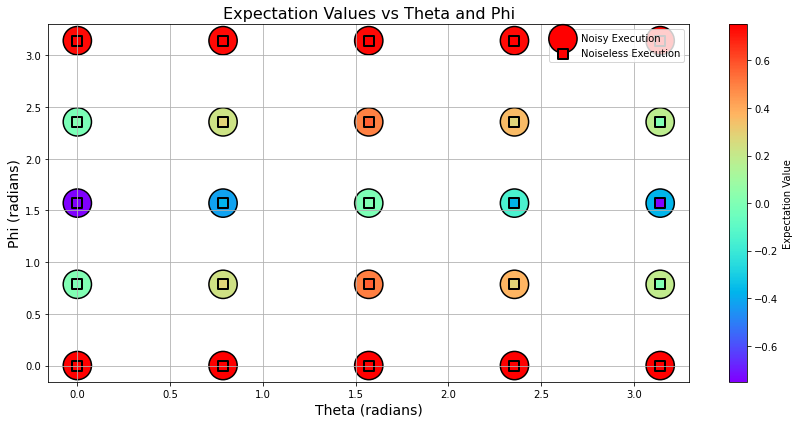

In [419]:
import numpy as np
import matplotlib.pyplot as plt

# Example data: (theta, phi) pairs
theta_phi_pairs = [
    (0.0, 0.0), (0.0, 0.7853981633974483), (0.0, 1.5707963267948966), (0.0, 2.356194490192345), (0.0, 3.141592653589793),
    (0.7853981633974483, 0.0), (0.7853981633974483, 0.7853981633974483), (0.7853981633974483, 1.5707963267948966), 
    (0.7853981633974483, 2.356194490192345), (0.7853981633974483, 3.141592653589793),
    (1.5707963267948966, 0.0), (1.5707963267948966, 0.7853981633974483), (1.5707963267948966, 1.5707963267948966), 
    (1.5707963267948966, 2.356194490192345), (1.5707963267948966, 3.141592653589793),
    (2.356194490192345, 0.0), (2.356194490192345, 0.7853981633974483), (2.356194490192345, 1.5707963267948966), 
    (2.356194490192345, 2.356194490192345), (2.356194490192345, 3.141592653589793),
    (3.141592653589793, 0.0), (3.141592653589793, 0.7853981633974483), (3.141592653589793, 1.5707963267948966),
    (3.141592653589793, 2.356194490192345), (3.141592653589793, 3.141592653589793)
]

# Noisy and noiseless expectation values
expectation_value_noisy_execution = np.array([
    0.96411133, 0.01849365, -0.93652344, -0.00408936, 0.93939209,
    0.96386719, 0.3079834, -0.51843262, 0.30230713, 0.93786621,
    0.96496582, 0.64971924, 0.00183105, 0.6416626, 0.94195557,
    0.96557617, 0.48858643, -0.18127441, 0.46710205, 0.94195557,
    0.96533203, 0.25238037, -0.456604, 0.23846436, 0.9395752
])

expectation_value_noiseless_execution = np.array([
    7.51229344e-01, -7.93926706e-03, -7.51229344e-01, 7.93926706e-03,
    7.51229344e-01, 7.51229344e-01, 2.80162446e-01, -3.75869277e-01, 
    2.82697621e-01, 7.51229344e-01, 7.51229344e-01, 5.66935942e-01, 
    -3.45860493e-17, 5.59293402e-01, 7.51229344e-01, 7.51229344e-01,
    2.86645633e-01, -3.74130723e-01, 2.77952988e-01, 7.51229344e-01, 
    7.51229344e-01, 1.22934395e-03, -7.48770656e-01, 1.22934395e-03, 
    7.51229344e-01
])

# Extracting theta and phi values from the pairs
theta_values = [pair[0] for pair in theta_phi_pairs]
phi_values = [pair[1] for pair in theta_phi_pairs]

# Setting the same colormap for both noisy and noiseless expectation values
cmap = 'rainbow'  # You can change to any colormap you prefer, e.g., 'inferno', 'plasma', etc.

# Creating scatter plot for noisy and noiseless expectation values
plt.figure(figsize=(12, 6))

# Noisy execution
plt.scatter(theta_values, phi_values, c=expectation_value_noisy_execution, cmap=cmap, s=800, marker='o', label='Noisy Execution', edgecolor='black', linewidth=1.5)
# Noiseless execution
plt.scatter(theta_values, phi_values, c=expectation_value_noiseless_execution, cmap=cmap, s=100, marker='s', label='Noiseless Execution', edgecolor='black', linewidth=2)

# Adding colorbars
plt.colorbar(label='Expectation Value')

# Labels and title
plt.title('Expectation Values vs Theta and Phi', fontsize=16)
plt.xlabel('Theta (radians)', fontsize=14)
plt.ylabel('Phi (radians)', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

#### Q7. Building towards error mitigation

In this step you will create the framework for error mitigation. Obtaining error mitigated results in not possible on a noisy simulator. For this example, we want the following

- Apply Dynamical Decoupling with `XY4` pulse
- Apply Zero Noise Extrapolation with `[1,2,3]` as the noise factors and `exponential` extrapolator
- Turn on Gate Twirling
- Turn off Measurement Twirling
- Turn off Measurement Error Mitigation

Construct an `EstimatorV2` object with the previously stated error mitigation and suppression options.

In [406]:
estimator = EstimatorV2(backend)

# Apply Dynamical Decoupling with XY4 pulse
estimator.options.dynamical_decoupling.sequence_type='XY4'

# Apply Zero Noise Extrapolation with [1,2,3] as the noise factors
#estimator.options.resilience.zne_mitigation = True

estimator.options.resilience.zne.noise_factors = [1,2,3]

#Apply Zero Noise Extrapolation with exponential extrapolator
estimator.options.resilience.zne.extrapolator = "exponential"

# Turn on Gate Twirling
estimator.options.twirling.enable_gates = True

# Turn off Measurement Twirling
estimator.options.twirling.enable_measure = False

# Turn off Measurement Error Mitigation
estimator.options.resilience.measure_mitigation = False

In [407]:
expectation_value_error_mitigation = np.zeros((25))
for i in range(25):
    job = estimator.run([pub[i]])
    result = job.result()[0]
    expectation_value_error_mitigation[i] = result.data.evs

/opt/homebrew/lib/python3.9/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'sequence_type': 'XY4'}, 'resilience': {'measure_mitigation': False, 'zne': {'noise_factors': [1.0, 2.0, 3.0], 'extrapolator': 'exponential'}}, 'twirling': {'enable_gates': True, 'enable_measure': False}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/opt/homebrew/lib/python3.9/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'sequence_type': 'XY4'}, 'resilience': {'measure_mitigation': False, 'zne': {'noise_factors': [1.0, 2.0, 3.0], 'extrapolator': 'exponential'}}, 'twirling': {'enable_gates': True, 'enable_measure': False}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/opt/homebrew/lib/python3.9/site-packages/qiskit_ibm_runtime/fak

/opt/homebrew/lib/python3.9/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'sequence_type': 'XY4'}, 'resilience': {'measure_mitigation': False, 'zne': {'noise_factors': [1.0, 2.0, 3.0], 'extrapolator': 'exponential'}}, 'twirling': {'enable_gates': True, 'enable_measure': False}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/opt/homebrew/lib/python3.9/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'sequence_type': 'XY4'}, 'resilience': {'measure_mitigation': False, 'zne': {'noise_factors': [1.0, 2.0, 3.0], 'extrapolator': 'exponential'}}, 'twirling': {'enable_gates': True, 'enable_measure': False}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/opt/homebrew/lib/python3.9/site-packages/qiskit_ibm_runtime/fak

In [408]:
expectation_value_error_mitigation

array([ 9.64050293e-01,  1.37939453e-02, -9.32739258e-01,  8.54492188e-04,
        9.40673828e-01,  9.63439941e-01,  3.11279297e-01, -5.19531250e-01,
        3.08349609e-01,  9.38171387e-01,  9.64660645e-01,  6.57653809e-01,
        6.16455078e-03,  6.37878418e-01,  9.38842773e-01,  9.64233398e-01,
        4.74853516e-01, -1.86279297e-01,  4.67407227e-01,  9.41955566e-01,
        9.61975098e-01,  2.55920410e-01, -4.54895020e-01,  2.40234375e-01,
        9.44335938e-01])

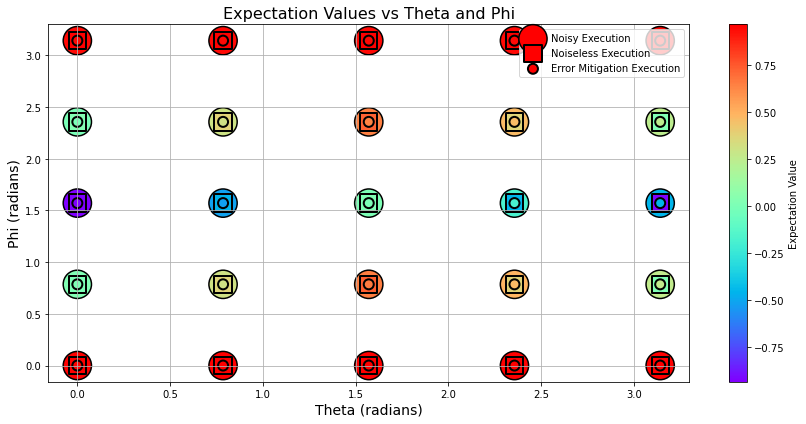

In [423]:
import numpy as np
import matplotlib.pyplot as plt

# Example data: (theta, phi) pairs
theta_phi_pairs = [
    (0.0, 0.0), (0.0, 0.7853981633974483), (0.0, 1.5707963267948966), (0.0, 2.356194490192345), (0.0, 3.141592653589793),
    (0.7853981633974483, 0.0), (0.7853981633974483, 0.7853981633974483), (0.7853981633974483, 1.5707963267948966), 
    (0.7853981633974483, 2.356194490192345), (0.7853981633974483, 3.141592653589793),
    (1.5707963267948966, 0.0), (1.5707963267948966, 0.7853981633974483), (1.5707963267948966, 1.5707963267948966), 
    (1.5707963267948966, 2.356194490192345), (1.5707963267948966, 3.141592653589793),
    (2.356194490192345, 0.0), (2.356194490192345, 0.7853981633974483), (2.356194490192345, 1.5707963267948966), 
    (2.356194490192345, 2.356194490192345), (2.356194490192345, 3.141592653589793),
    (3.141592653589793, 0.0), (3.141592653589793, 0.7853981633974483), (3.141592653589793, 1.5707963267948966),
    (3.141592653589793, 2.356194490192345), (3.141592653589793, 3.141592653589793)
]

# Noisy, noiseless and error-mitigated expectation values
expectation_value_noisy_execution = np.array([
    0.96411133, 0.01849365, -0.93652344, -0.00408936, 0.93939209,
    0.96386719, 0.3079834, -0.51843262, 0.30230713, 0.93786621,
    0.96496582, 0.64971924, 0.00183105, 0.6416626, 0.94195557,
    0.96557617, 0.48858643, -0.18127441, 0.46710205, 0.94195557,
    0.96533203, 0.25238037, -0.456604, 0.23846436, 0.9395752
])

expectation_value_noiseless_execution = np.array([
    7.51229344e-01, -7.93926706e-03, -7.51229344e-01, 7.93926706e-03,
    7.51229344e-01, 7.51229344e-01, 2.80162446e-01, -3.75869277e-01, 
    2.82697621e-01, 7.51229344e-01, 7.51229344e-01, 5.66935942e-01, 
    -3.45860493e-17, 5.59293402e-01, 7.51229344e-01, 7.51229344e-01,
    2.86645633e-01, -3.74130723e-01, 2.77952988e-01, 7.51229344e-01, 
    7.51229344e-01, 1.22934395e-03, -7.48770656e-01, 1.22934395e-03, 
    7.51229344e-01
])

expectation_value_error_mitigation = np.array([
    9.64050293e-01, 1.37939453e-02, -9.32739258e-01, 8.54492188e-04,
    9.40673828e-01, 9.63439941e-01, 3.11279297e-01, -5.19531250e-01,
    3.08349609e-01, 9.38171387e-01, 9.64660645e-01, 6.57653809e-01,
    6.16455078e-03, 6.37878418e-01, 9.38842773e-01, 9.64233398e-01,
    4.74853516e-01, -1.86279297e-01, 4.67407227e-01, 9.41955566e-01,
    9.61975098e-01, 2.55920410e-01, -4.54895020e-01, 2.40234375e-01,
    9.44335938e-01
])

# Extracting theta and phi values from the pairs
theta_values = [pair[0] for pair in theta_phi_pairs]
phi_values = [pair[1] for pair in theta_phi_pairs]

# Set the same colormap for all three
cmap = 'rainbow'

# Create scatter plot for noisy, noiseless, and error-mitigated expectation values
plt.figure(figsize=(12, 6))

# Noisy execution
plt.scatter(theta_values, phi_values, c=expectation_value_noisy_execution, cmap=cmap, s=800, marker='o', label='Noisy Execution', edgecolor='black', linewidth=1.5)
# Noiseless execution
plt.scatter(theta_values, phi_values, c=expectation_value_noiseless_execution, cmap=cmap, s=300, marker='s', label='Noiseless Execution', edgecolor='black', linewidth=2)
# Error mitigation execution
plt.scatter(theta_values, phi_values, c=expectation_value_error_mitigation, cmap=cmap, s=100, marker='o', label='Error Mitigation Execution', edgecolor='black', linewidth=2)

# Adding colorbars
plt.colorbar(label='Expectation Value')

# Labels and title
plt.title('Expectation Values vs Theta and Phi', fontsize=16)
plt.xlabel('Theta (radians)', fontsize=14)
plt.ylabel('Phi (radians)', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

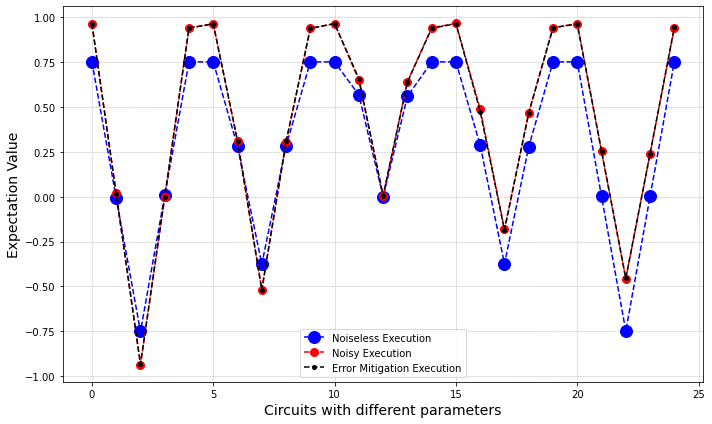

In [425]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data with customizations
ax.plot(expectation_value_noiseless_execution, marker='o', color='b', linestyle='--', markersize=12, label='Noiseless Execution')
ax.plot(expectation_value_noisy_execution, marker='o', color='r', linestyle='--', markersize=8, label='Noisy Execution')
ax.plot(expectation_value_error_mitigation, marker='o', color='k', linestyle='--', markersize=4, label='Error Mitigation Execution')

# Add grid, title, and axis labels
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
#ax.set_title('Expectation Values', fontsize=16)
ax.set_xlabel('Circuits with different parameters', fontsize=14)
ax.set_ylabel('Expectation Value', fontsize=14)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [426]:
# I don't understand why noisy and error mitigation are same. Is something wrong here?